<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left"></td>
<h2 style="white-space: nowrap">Signal Processing for Functional Brain Imaging Laboratories (MICRO-513)</h2>
<hr style="clear:both"></hr>
<h1><font color='black'>Lab 2 - Multivariate Methods</font></h1>

<div style="background-color:#F0F0F0;padding:4px">
    <p style="margin:4px;"><b>Released</b>: April 29, 2021</p>
    <p style="margin:4px;"><b>Submission</b>: <span style="color:red">May 4, 2021</span> 
</div>

## Student Name: Emery Sébastien

## Student SCIPER: 258565

After filling the previous cell with your information, run the next cell to make sure that you have all required Python libraries installed. Once you have done that, run the cell below it to import all the libraries you will be using and to set up your environment. 

In [1]:
!pip install dipy
!pip install fury
!pip install nibabel
!pip install nistats
!pip install nilearn
!pip install tensorly

  Using cached nibabel-3.2.1-py3-none-any.whl (3.3 MB)
  Using cached fury-0.7.0-py3-none-any.whl (294 kB)
  Using cached nistats-0.0.1rc0-py2.py3-none-any.whl (121 kB)
  Using cached nilearn-0.7.1-py3-none-any.whl (3.0 MB)
  Using cached tensorly-0.6.0-py3-none-any.whl (160 kB)


In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from dipy.viz import regtools
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from tensorly.decomposition import parafac
from IPython.display import Image

save_results = 'results/'
if not os.path.exists(save_results):
    os.makedirs(save_results)
    
%matplotlib inline

C:\Users\sebbe\anaconda3\lib\site-packages\nilearn\datasets\__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In this lab, we are going to apply different multivariate techniques to fMRI data: PLS, Group ICA and Tensor ICA.

<div class = 'alert alert-success'>
    
**Note:** This Jupyter Notebook contains all the necessary code for the lab. To solve the notebook, you will need to read and execute the following sections. Pay attention to comments in the code section as they explain the workflow. You will be graded with Multiple Choice Questions (*MCQ*), where you will have several possible answers, only one of them correct. 
    
Good luck! We hope you enjoy the lab. 
</div>

## Index
1. [PLS](#1.-PLS-(1-point)) (**1 Point**)
2. [Group ICA](#2.-Group-ICA-(1-Point)) (**1 Point**)
3. [Tensor ICA](#3.-Tensor-ICA-(1-Point)) (**1 Point**)

# 1. PLS (1 point)
[Back to Index](#Index)

For the PLS analysis, we are going to use $n=20$ subjects with one contrast map (image, dim: [91, 109, 91] ) per subject. So in total, the number of input imaging data ($\textbf{X}$) is 20 flattened contrast maps ($X_{im} \in {\rm I\!R^{d_{im} \times n}}, d_{im}= 902629, n = 20$) )
    
For the behavioural input data ($\textbf{Y}$), two behavioural scores per subjects are used ($Y_{beh} \in {\rm I\!R^{d_{beh} \times n}}, d_{beh}= 2, n = 20$) )

In [3]:
#* Read  contrast maps of all subjects and build the X matrix
data_dir_template = 'LAB2_data/PLS/Data/sub_{}/contrastMap.nii'

N_subj = 20                      # Number of subjects
tmp    = nib.load(data_dir_template.format(1))
x1, y1, z1 = tmp.shape              # voxel size of the contrast maps

tmp    = tmp.get_fdata().flatten()
N_vox  = tmp.shape[0]    # Number of voxels
del tmp

#* initialize X
X      = np.zeros((N_vox, N_subj)) # voxel_num X subj_num

for i in range(N_subj):
    voxel_array = nib.load(data_dir_template.format(i+1)).get_fdata().flatten()
    X[:,i]      = voxel_array.copy()
    
X      = zscore(X, axis = 0) # z-scoring voxel activity across subjects
X      = np.nan_to_num(X,0) # replace nan with 0s

print("X matrix size: ", X.shape)

X matrix size:  (902629, 20)


In [4]:
#* Read behavioral data and build the Y matrix
behVar = loadmat('LAB2_data/PLS/Data/behavior.mat')['behVar']

Y = np.zeros(behVar.shape) # size: N_beh x N_subj
Y[0,:] = zscore(behVar[0,:])    # z-scoring of the first measure
Y[1,:] = zscore(behVar[1,:])    # z-scoring of the second measure

print("Y matrix size: ", Y.shape)

Y matrix size:  (2, 20)


In [5]:
#* Build the cross-corretaion matrix (R)
R     = np.dot(Y,X.T); # size: N_beh x N_vox
print("R matrix size: ", R.shape)

#* Do Singular Value Decomposition (SVD) of R
U,D,V = np.linalg.svd(R, full_matrices=False) # U: N_beh x N_beh, D: N_beh x 1, V: N_beh x N_vox

#* Get the Latent Variables (LVs)
Lx    = np.dot(V,X)  # size: N_beh x N_subj
Ly    = np.dot(U,Y)  # size: N_beh x N_subj

print('Number of singular values is equal to the number of behavioral measures: ', D.shape[0])

R matrix size:  (2, 902629)
Number of singular values is equal to the number of behavioral measures:  2



 The Singular values:  [2552.18920751   12.92148597]


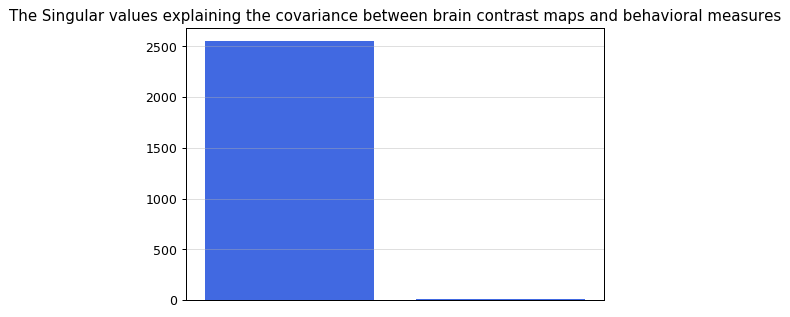

In [6]:
#* Plot singular values
plt.figure(dpi=90)
plt.bar([1,2],D, color='royalblue'); 
plt.grid(alpha=0.4); 
plt.title("The Singular values explaining the covariance between brain contrast maps and behavioral measures");plt.xticks([])
plt.savefig(save_results + "pls_sign_values.png", dpi=300)

print("\n The Singular values: ", D)

### MCQ

For 0.5 points, by observing the singular values (D), answer the following question.

* Q.1 Which of the following statements is correct?
 
    1. Only the first component is important because it's much larger than the second one
    2. Only the second component is important because it's much smaller than the first one
    3. Both components could be important because the value doesn't say anything about their importance
    4. The difference between the two is important.

In the next cell, **change the value of the variable `answer_q1`** to the answer you consider correct. Then, run the cell below it to check that your answer is valid. 

In [7]:
# Do not change the name of this variable
answer_q1 = 1
# YOUR CODE HERE
# raise NotImplementedError()

In [8]:
assert answer_q1 in [1, 2, 3, 4], 'Valid answers are 1, 2, 3 and 4'

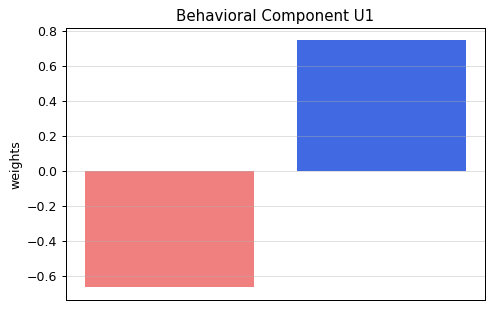

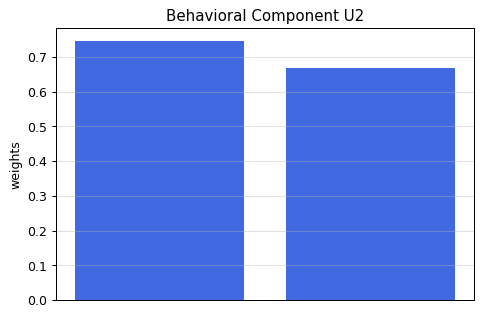

In [9]:
#* Plot the behavioral components (matrix U)
plt.figure(dpi=90)
plt.bar([1,2],U[0,:], color=['lightcoral','royalblue'])
plt.grid(alpha=0.4); plt.xticks([]); plt.ylabel("weights")
plt.title('Behavioral Component U1')
plt.savefig(save_results + "pls_behav_U1.png", dpi=300)

plt.figure(dpi=90)
plt.bar([1,2],U[1,:], color = ['royalblue', 'royalblue'])
plt.grid(alpha=0.4); plt.xticks([]); plt.ylabel("weights")
plt.title('Behavioral Component U2')
plt.savefig(save_results + "pls_behav_U2.png", dpi=300)

In [10]:
#* Information needed for plotting
#* Read T1-weighted template
T1w_img = nib.load('LAB2_data/PLS/Data/T1w_restore_brain.nii')

# Get affine transform
affine = nib.load(data_dir_template.format(1)).affine

Spatial Component V1


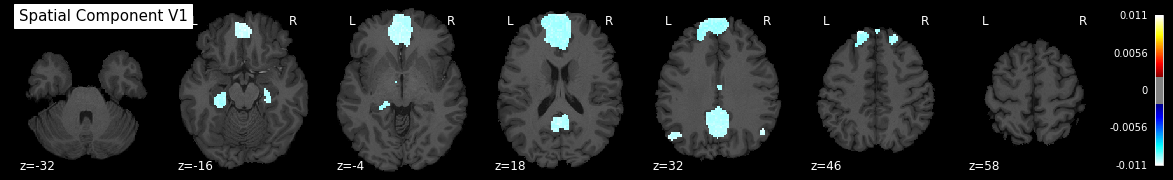

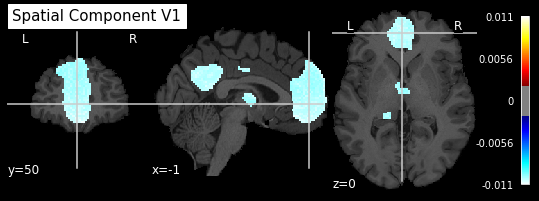

In [11]:
#* Plot the spatial components (matrix V)
print('Spatial Component V1')
V1_img = nib.Nifti1Image(np.reshape(V[0,:],(x1, y1, z1)), affine)

#* Plot different views
desired_views = ['z', 'ortho']
for view_ in desired_views:
    plot_stat_map(V1_img, display_mode=view_, title='Spatial Component V1',
                    colorbar=True, black_bg=True, bg_img=T1w_img, threshold=2*np.std(V[0,:]),)
                    #output_file=save_results + "pls_spatial_V1_{}.png".format(view_)) # uncomment to save plot
    

Spatial Component V2


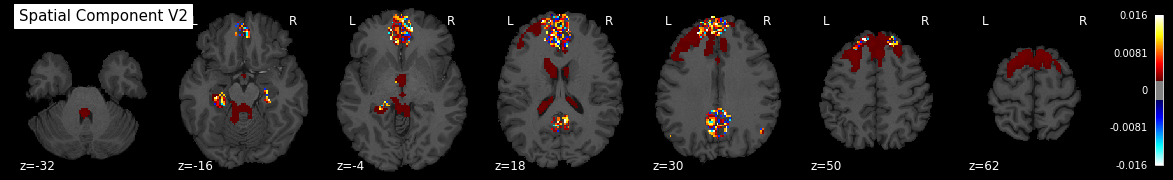

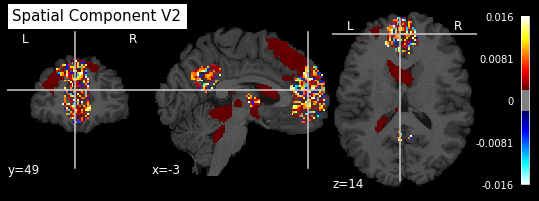

In [12]:
print('Spatial Component V2')
V2_img = nib.Nifti1Image(np.reshape(V[1,:],(x1, y1, z1)), affine)

#* Plot different views
desired_views = ['z', 'ortho']
for view_ in desired_views:
    plot_stat_map(V2_img, display_mode=view_, title='Spatial Component V2',
                colorbar=True, black_bg=True, bg_img=T1w_img, threshold=2*np.std(V[1,:]),)
                #output_file=save_results + "pls_spatial_V2_{}.png".format(view_)) # uncomment to save plot

## MCQ

Now that you have plotted the behavioral components and the spatial components, for 0.5 points answer the following question.

* Q2: Which statement concerning the [Posterior Cingulate Cortex (PCC)](https://en.wikipedia.org/wiki/Posterior_cingulate_cortex) and the [Medial Prefrontal Cortex (mPFC)](https://en.wikipedia.org/wiki/Prefrontal_cortex) is true?

    1. The PCC and the mPFC are negatively correlated with behavioral score 1 and positively correlated with behavioral score 2.
    2. The PCC and the mPFC are positively correlated with behavioral score 1 and positively correlated with behavioral score 2.
    3. The PCC and the mPFC are positively correlated with behavioral score 1 and negatively correlated with behavioral score 2.
    4. The PCC and the mPFC are not correlated with any behavior score.

In the next cell, **change the value of the variable `answer_q2`** to the answer you consider correct. Then, run the cell below it to check that your answer is valid. 

In [13]:
# Do not change the name of this variable
answer_q2 = 3
# YOUR CODE HERE
# raise NotImplementedError()

In [14]:
assert answer_q2 in [1, 2, 3, 4], 'Valid answers are 1, 2, 3 and 4'

### 2. Group ICA (1 Point)
[Back to Index](#Index)

For the Group ICA analysis, we are going to use data from studyforest. Subjects are watching the movie "forest gump" during fMRI acquisition. Here we take $n=5$ subjects with 451 smoothed volumes (image dim: [61, 73, 61] ) per subject. So in total, the number of input imaging data  concatenated across subjects is: $$X \in {\rm I\!R^{(n _{subj}\times n_{images}) \times d}}$$ with $$n_{subj} = 15, n_{images}=200, d = 271633$$

Note that we only take a small part of the movie (1/8th)

Citation: Hanke, M., Adelhöfer, N., Kottke, D. et al. A studyforrest extension, simultaneous fMRI and eye gaze recordings during prolonged natural stimulation. Sci Data 3, 160092 (2016). https://doi.org/10.1038/sdata.2016.92

In [15]:
path_func_img = 'LAB2_data/groupICA/Group_Data/StudyForest/s01run1/s6wCov_rfrun-1_bold001.nii'
img_ex = nib.load(path_func_img)
# Get affine transform
affine = nib.load(path_func_img).affine
x,y,z=img_ex.shape

N_vol=200
N_subj=15 # If your computer can't handle 15 subjects you can put the nb down
N_tot=N_vol*N_subj
#* Initialize X
X = np.zeros((N_tot,x*y*z)) # total_timepoints(15subj*200timepoints) x voxel_num
i = 0
n_nii  = 0
nb_subj_counted=0
for root, dirs, files in sorted(os.walk('LAB2_data/groupICA/Group_Data/StudyForest/')):
    nb_subj_counted=nb_subj_counted+1
    for file in sorted(files):
        if file.endswith('.nii'):
            if nb_subj_counted<N_subj+1:
                X[n_nii,:] = nib.load(root+'/'+file).get_fdata().flatten()
                n_nii+=1
X = zscore(X, axis = 1) # across subjects
X = np.nan_to_num(X,0) # nan to 0s
print("X matrix size: ", X.shape)

C:\Users\sebbe\anaconda3\lib\site-packages\scipy\stats\stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


X matrix size:  (3000, 271633)


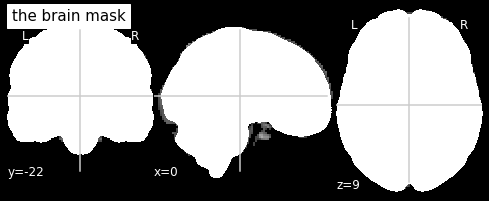

In [16]:
#* Build brain mask to restrict analysis within the brain
icbms = datasets.fetch_icbm152_2009()
masker = NiftiMasker(mask_img=icbms.mask)
plot_stat_map(icbms.mask, black_bg=True, title='the brain mask', colorbar=False,)
              #output_file=save_results + "ICA_brain_mask.png") # uncomment to save plot

<div class = 'alert alert-info'>

**Note:** In the lecture's slides the ICA model was defined as $X = S A$.  The matrix $A$ was the mixing matrix. Here, the Fast ICA model is defined as: $S = X W$. The matrix $W$ is the un-mixing matrix (inverse of $A$).
</div>

In [17]:
#* Run FastICA on X

S_dict = {}
nb_components = [4,20]

#* We will transpose the matrix X so that ICA algorithm operates on the voxels dimension.
#* In other words, the estimated sources (S) should be have dimensionality [#voxels]
for n in nb_components:
    
    # run PCA as a preprocessing step for ICA with twice the number of components
    n2=2*n
    pca = PCA(n_components=n2)
    H = pca.fit_transform(X.T)  # Reconstruct signals based on orthogonal components
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)
    ica = FastICA(n_components=n, random_state=1, max_iter=200)
    S_ = ica.fit_transform(H)  # Get the estimated sources (S)
    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_ # store the results in a dictionary

    print("Done")

Running FastICA with n = 4 components
(271633, 4)
Done
Running FastICA with n = 20 components
(271633, 20)
Done


In [18]:
print("The shape of the estimated Sources is: {}".format(S_.shape))

The shape of the estimated Sources is: (271633, 20)


Number of components:  4


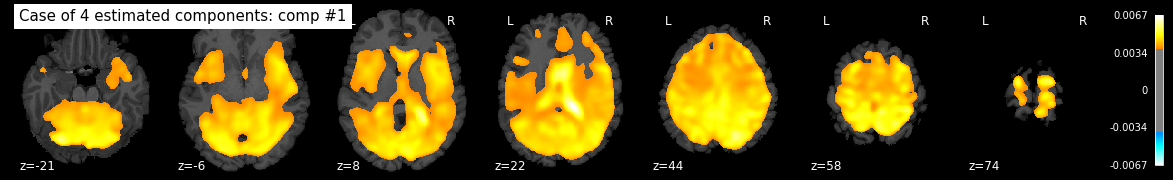

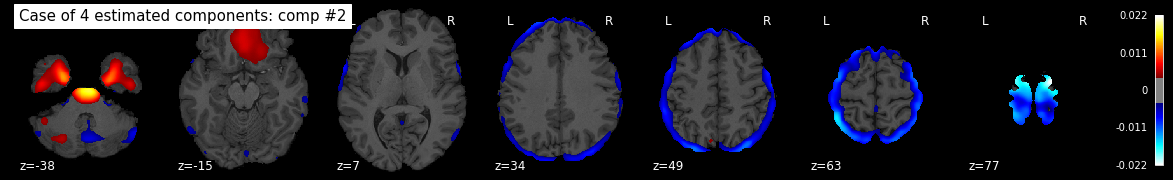

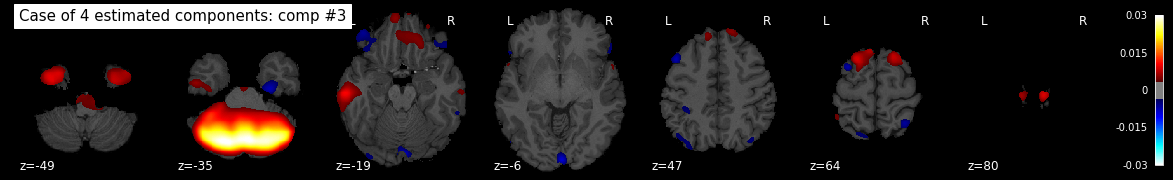

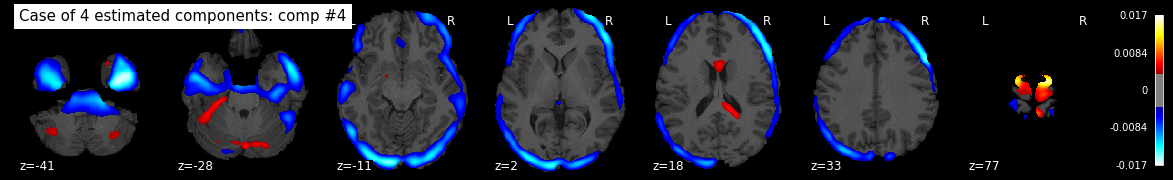

Number of components:  20


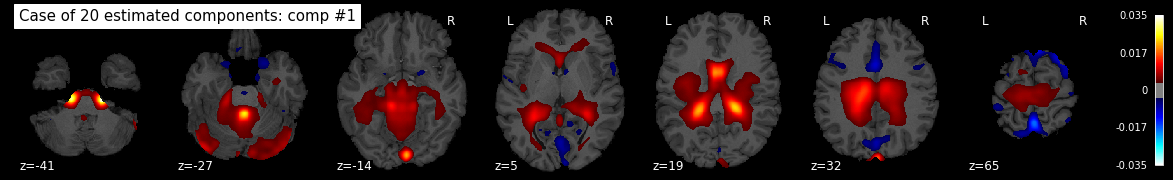

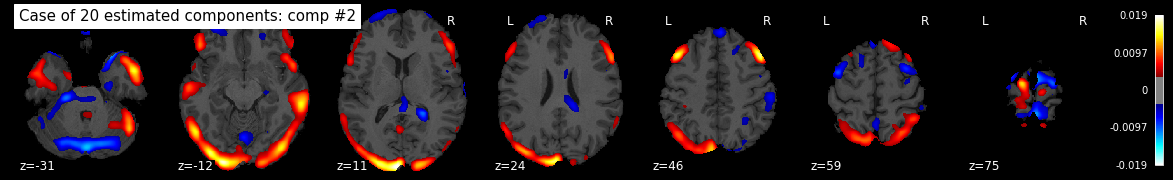

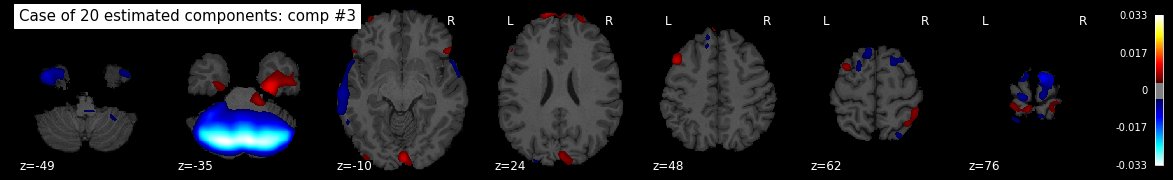

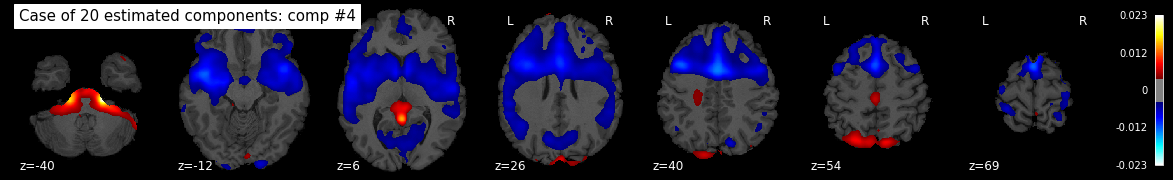

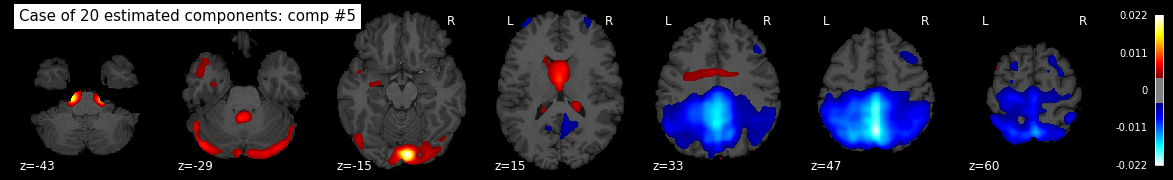

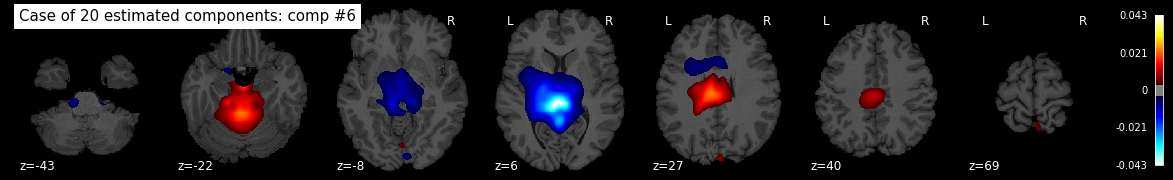

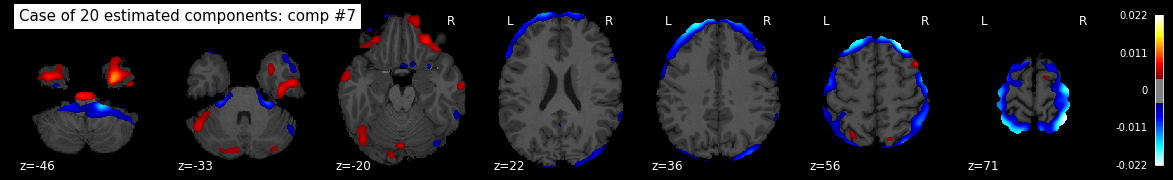

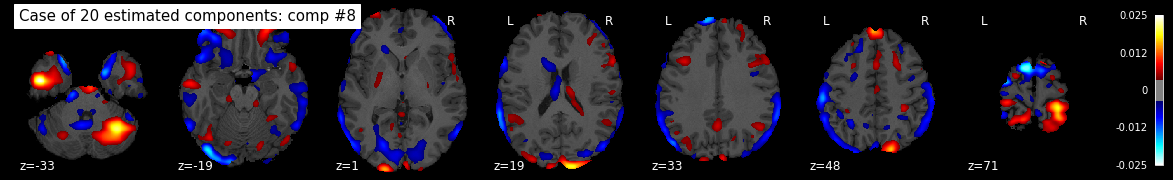

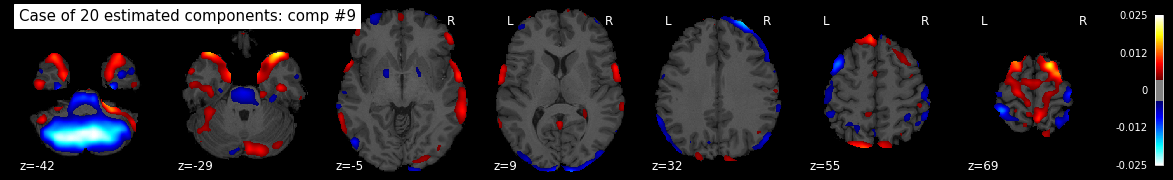

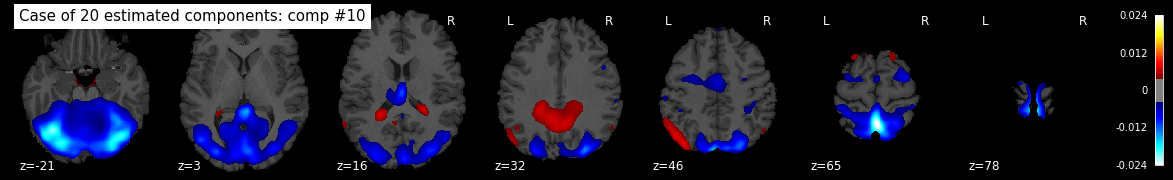

In [19]:
#* Plot the group-level independent components for the different number of requested components.
for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="z", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img,)
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()

Number of components:  4


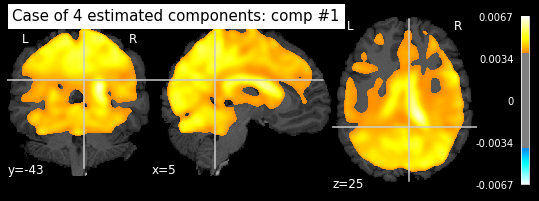

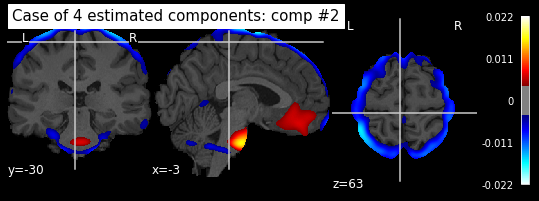

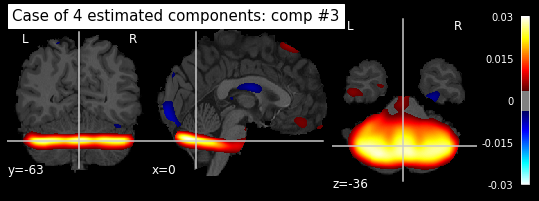

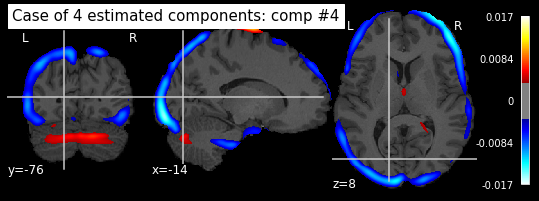

Number of components:  20


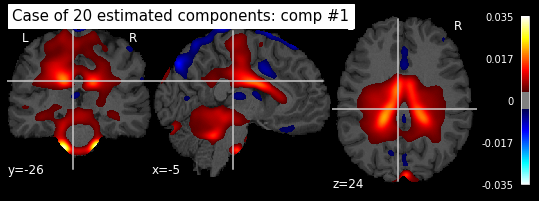

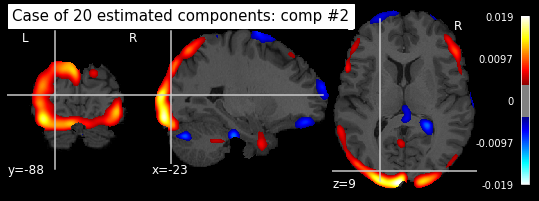

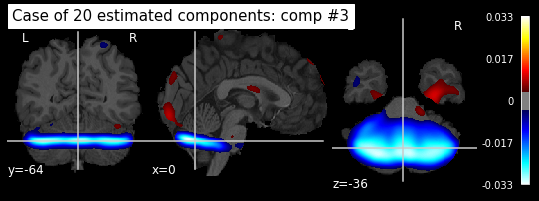

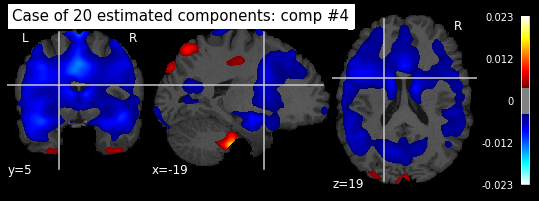

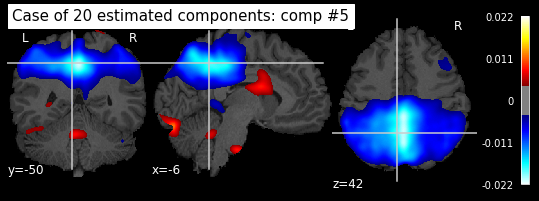

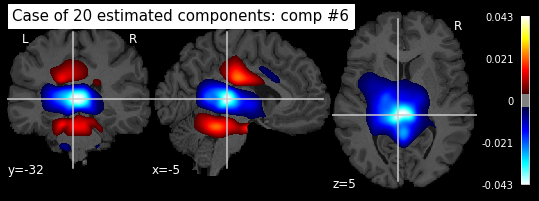

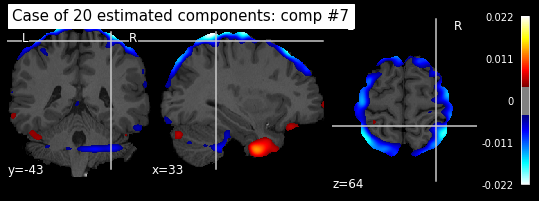

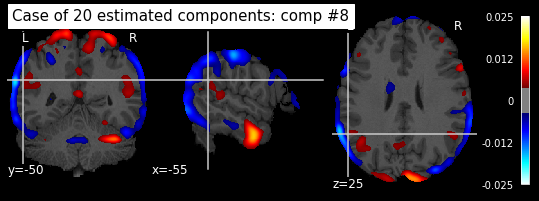

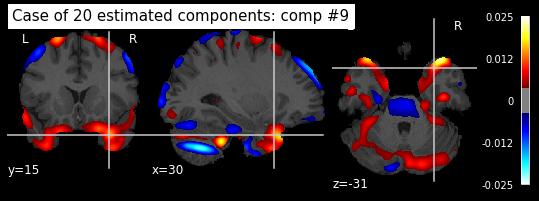

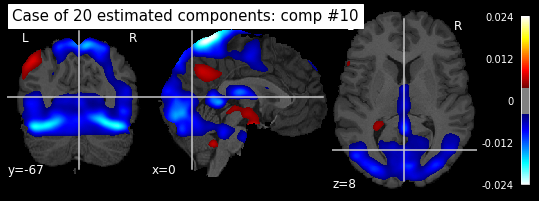

In [20]:
#* Plot the group-level independent components for the different number of requested components.
for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img,)
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()

## MCQ

We ran the analysis with different numbers of independent components. What do you observe? Similarities/Differences? For 0.5 points, investigate the images above and answer the following question.

* Q.3 Which of the following statements is **not** correct?

    1. Using a very high number of independent components (ICs) results in very localized components ("oversplitting")
    2. Using 20 independent components provides useful information since the individual components can be well distinguished
    3. Using 4 independent components results in no informative components ("overclumping")
    4. Using more independent components always provides more useful information

In the next cell, **change the value of the variable `answer_q3`** to the answer you consider correct. Then, run the cell below it to check that your answer is valid. 

In [21]:
# Do not change the name of this variable
answer_q3 = 4
# YOUR CODE HERE
# raise NotImplementedError()

In [22]:
assert answer_q3 in [1, 2, 3, 4], 'Valid answers are 1, 2, 3 and 4'

## MCQ

* Q.4 Which of the following questions is wrong?

    1. For the optimum number of components, there are still some artifactual components, for example some noise in the CSF, the cerebellum and the skull. In fact, ICA can even be used as a preprocessing step for denoising.
    2. If the number of components is really optimal, we shouldn't see any artifactual components. If there are artifacts it means the preprocessing isn't correct.
    3. The order of independent components will not necessarily remain the same after each FastICA run.
    4. Very often, one component is dedicated to edge artefact in the FastICA.

In the next cell, **change the value of the variable `answer_q4`** to the answer you consider correct. Then, run the cell below it to check that your answer is valid. 

In [23]:
# Do not change the name of this variable
answer_q4 = 2
# YOUR CODE HERE
# raise NotImplementedError()

In [24]:
assert answer_q4 in [1, 2, 3, 4], 'Valid answers are 1, 2, 3 and 4'

In [25]:
#Visually compare the results obtained after ICA with the known brain networks 
#displayed here. Do you find any of these networks in our ICA results? 

Image(url= "LAB2_data/RSNs.jpg")
#Martijn P. van den Heuvel, Hilleke E. Hulshoff Pol, Exploring the brain network: A review on resting-state fMRI functional connectivity, European Neuropsychopharmacology, Volume 20, Issue 8, 2010, Pages 519-534,

## MCQ

Visually compare the results obtained after ICA with the known brain networks displayed above. Do you find any of these networks in our ICA results? For 0.5 points, answer the following question.

* Q.5 Do you observe some overlap between our ICA components and the resting state networks (RSNs) in the images above?

    1. No we don't see any IC that matches the RSNs. That's normal since it's not resting state data.
    2. Yes, we see a few ICs that match more or less the RS data.
    3. No because in the image there are 8 networks and we didn't choose 8 ICs.
    4. Yes, we clearly see all the RS networks in our ICA components.

In the next cell, **change the value of the variable `answer_q4`** to the answer you consider correct. Then, run the cell below it to check that your answer is valid. 

In [26]:
# Do not change the name of this variable
answer_q5 = 2
# YOUR CODE HERE
# raise NotImplementedError()

In [27]:
assert answer_q5 in [1, 2, 3, 4], 'Valid answers are 1, 2, 3 and 4'

# 3. Tensor ICA (1 Point)
[Back to Index](#Index)

For the Tensor ICA analysis, we are going to use the same data as in the Group ICA case but first we will reshape them into 3D (dimensions: $[200, 271633, 15]$).

One of the X matrix' dimentions is now subject (x=timepoints, y=voxels, z=subjects)

In [28]:
#* Reshape X from previous exercise into a 3D volume
X_tmp = X.copy()
X = np.zeros((N_vol, x*y*z, N_subj)) 
for i in range(N_subj):
    X[:,:,i] = X_tmp[N_vol*i:N_vol*(i+1),:]
    
del(X_tmp,i) # free memory if needed
print("The input tensor's (X) shape is: {}".format(X.shape))

The input tensor's (X) shape is: (200, 271633, 15)


In [29]:
#* Run Tensor decomposition.
components = 8
    
T = parafac(X,components)

A = T[1][0]   # Mixing matrix
S = T[1][1].T # Spatially independent components
C = T[1][2]   # Subject loadings

In [31]:
print(S.shape)

(8, 271633)


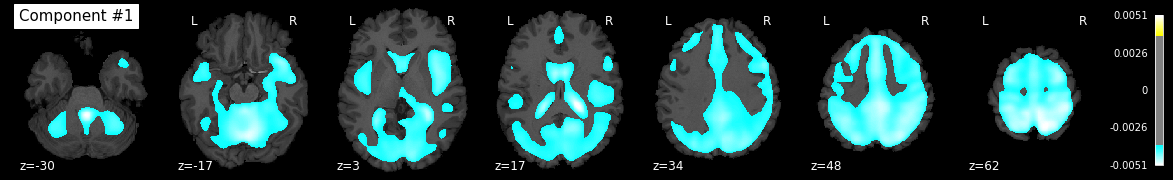

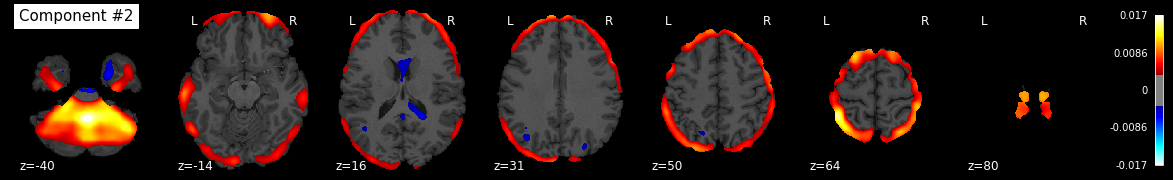

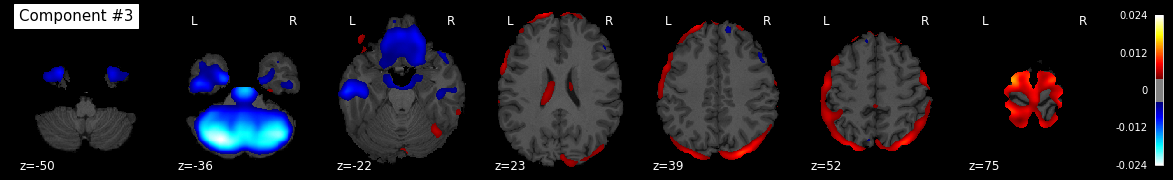

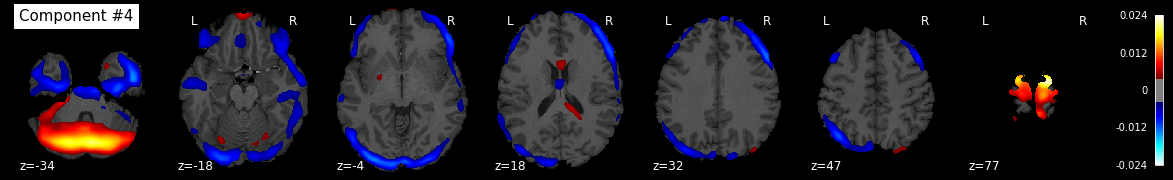

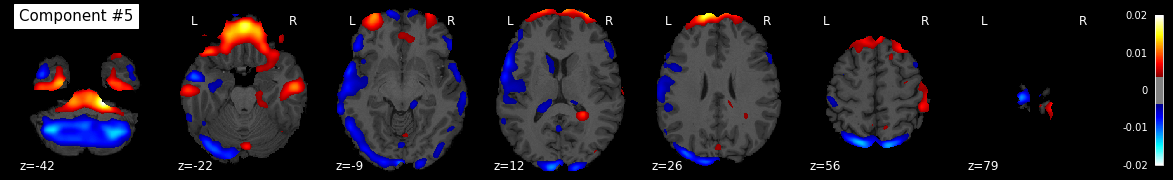

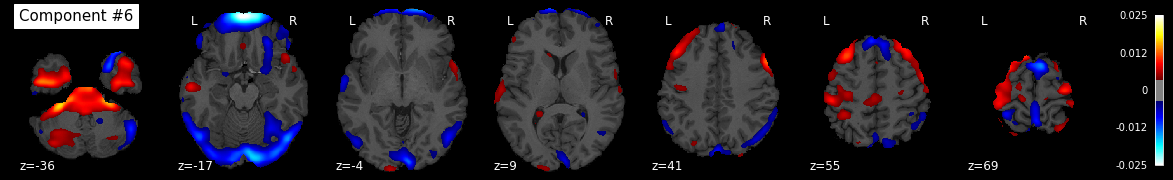

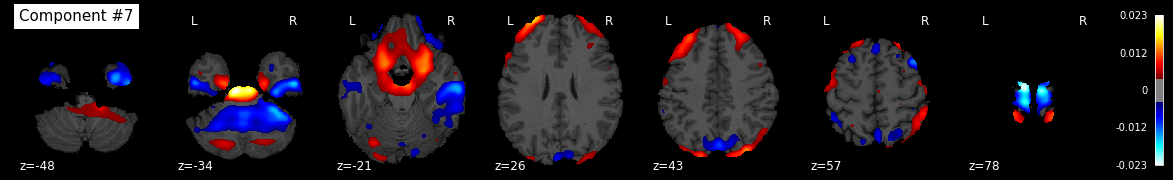

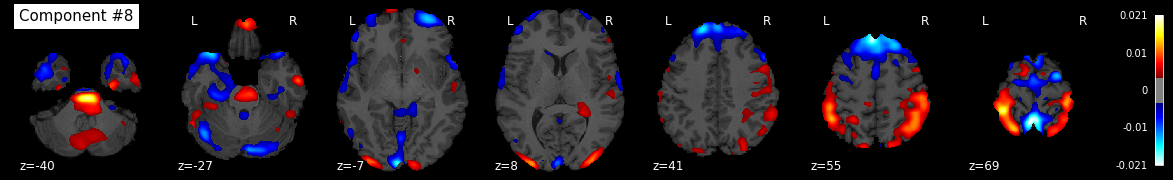

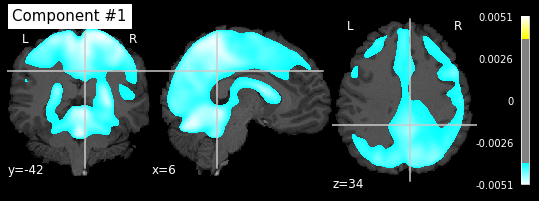

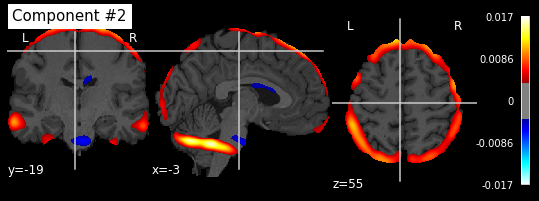

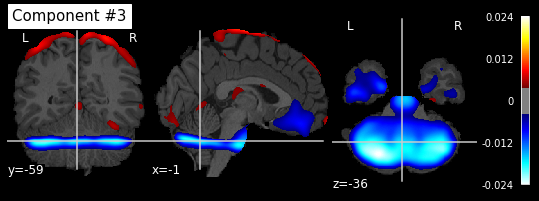

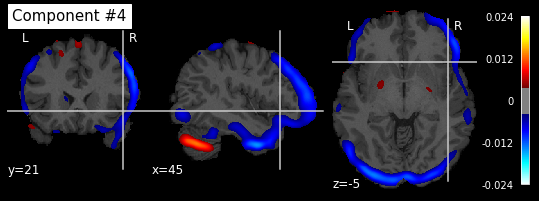

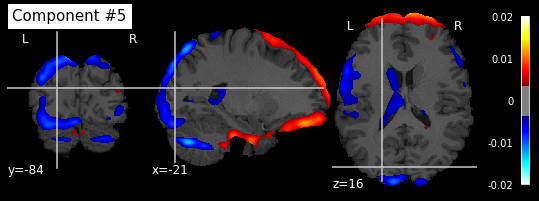

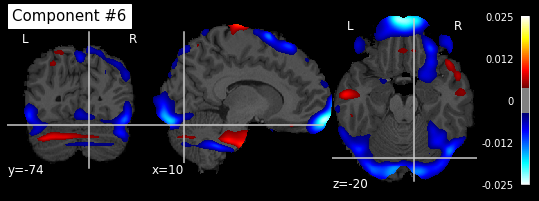

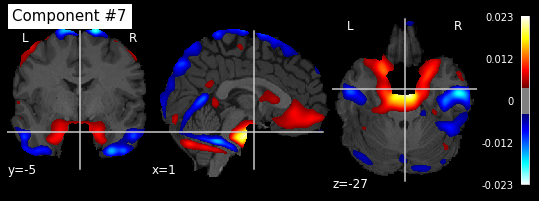

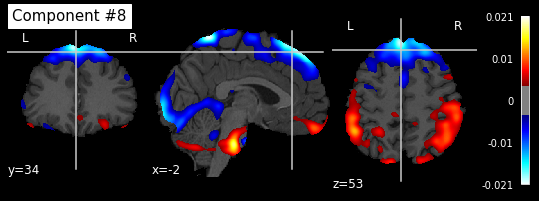

In [30]:
#* Plot the components
path_func_img = 'LAB2_data/groupICA/Group_Data/StudyForest/s01run1/s6wCov_rfrun-1_bold001.nii'
affine = nib.load(path_func_img).affine

desired_views = ["z", "ortho"]
for view_ in desired_views:
    for idx,s in enumerate(S):
        s_img = nib.Nifti1Image(np.reshape(s,(x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode=view_, title="Component #{}".format(idx+1),
                colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img)
        plt.show()

## MCQ

For 0.5 points, review the ICA theory and answer the following question.

* Q.5 What is the main advantage and disadvantage of Tensor ICA compared to Group-ICA?

    1. Tensor ICA has a better spacial resolution but a smaller sensitivity
    2. Tensor ICA incorporates the anatomical (3D) structure of the data but has a higher computational cost
    3. Tensor ICA has a lower computational cost but can generate less independent components
    4. Tensor ICA has a larger field of application but only works on Linux operating systems

In the next cell, **change the value of the variable `answer_q5`** to the answer you consider correct. Then, run the cell below it to check that your answer is valid.

In [32]:
# Do not change the name of this variable
answer_q5 = 2
# YOUR CODE HERE
# raise NotImplementedError()

In [33]:
assert answer_q5 in [1, 2, 3, 4], 'Valid answers are 1, 2, 3 and 4'

Re-run the Tensor ICA for more than 4 components (change the components parameter) and answer the following question for 0.5 points.

* Q.6 Which of the following statements concerning the similarities/differences between the Tensor ICA and the Group ICA results is correct?

    1. No similar components can be observed because Tensor ICA generates 3D components and Group ICA generates 2D components
    2. Some similar components can be observed because they are present in all fMRI scans
    3. Some similar components can be observed because the same data was used
    4. There is no difference between the two results because the same data was used

In the next cell, **change the value of the variable `answer_q6`** to the answer you consider correct. Then, run the cell below it to check that your answer is valid.

In [34]:
# Do not change the name of this variable
answer_q6 = 3
# YOUR CODE HERE
# raise NotImplementedError()

In [35]:
assert answer_q6 in [1, 2, 3, 4], 'Valid answers are 1, 2, 3 and 4'

<div class = 'alert alert-success'>

Congratulations on finishing the second graded lab! Don't forget to hand it in. 
</div>